# Chapter 5

In [1]:
import collections.abc
#hyper needs the four following aliases to be done manually.
collections.Iterable = collections.abc.Iterable

import os
import warnings

import arviz as az
import daft
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

from causalgraphicalmodels import CausalGraphicalModel
from scipy import stats
from scipy.interpolate import griddata

warnings.simplefilter(action="ignore", category=FutureWarning)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
%config Inline.figure_format = 'retina'
az.style.use("arviz-darkgrid")
np.random.seed(0)

In [3]:
# Load data
data = pd.read_csv("/code/data/WaffleDivorce.csv", delimiter=";")

In [4]:
data.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


In [5]:
def standardize(series):
    """Standardize a pandas series"""
    std_series = (series - series.mean()) / series.std()
    return std_series

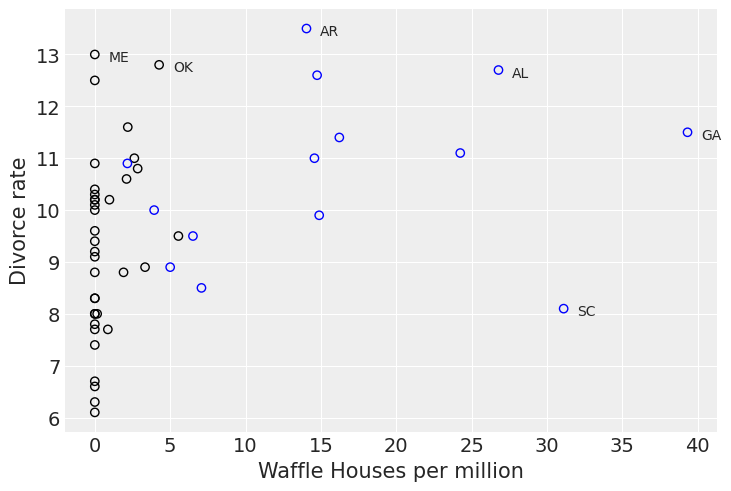

In [6]:
# Fig 5.1, missing mean
fig, ax = plt.subplots()

# assign colours to confederate states
colors = {"1": "blue", "0": "black"}

ax.scatter(
    data["WaffleHouses"] / data["Population"],
    data["Divorce"],
    lw=1,
    color=(0, 0, 0, 0),
    edgecolor=data["South"].apply(lambda x: colors[str(x)]),
)

ax.set_xlabel("Waffle Houses per million")
ax.set_ylabel("Divorce rate")

# take only the states with Divorce rate over 12.6 or number of Waffle houses per million inhabitants over 30
selection = data[(data["Divorce"] > 12.6) | (data["WaffleHouses"] / data["Population"] > 30)]

# label those points
for state, div, ratio in zip(
    selection["Loc"],
    selection["WaffleHouses"] / selection["Population"],
    selection["Divorce"],
):
    ax.annotate(f"{state}", xy=(div, ratio), textcoords="offset points", xytext=(10, -5))

Text(0.5, 0, 'Median age marriage')

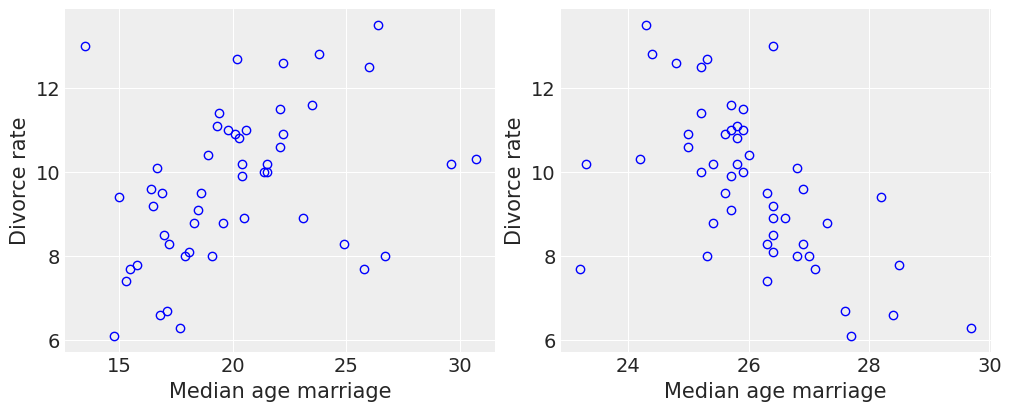

In [7]:
# Fig 5.2, missing mean and CI
fid, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].scatter(data["Marriage"], data["Divorce"], lw=1, color=(0, 0, 0, 0), edgecolor="b")
ax[0].set_ylabel("Divorce rate")
ax[0].set_xlabel("Median age marriage")

ax[1].scatter(data["MedianAgeMarriage"], data["Divorce"], lw=1, color=(0, 0, 0, 0), edgecolor="b")
ax[1].set_ylabel("Divorce rate")
ax[1].set_xlabel("Median age marriage")

#### Code 5.1

In [8]:
# Standardize regressors and target
data["Divorce_std"] = standardize(data["Divorce"])
data["Marriage_std"] = standardize(data["Marriage"])
data["MedianAgeMarriage_std"] = standardize(data["MedianAgeMarriage"])

#### Code 5.2

In [9]:
data["MedianAgeMarriage"].std()

1.2436303013880823

#### Code 5.3

In [10]:
with pm.Model() as m_5_1:
    a = pm.Normal("a", 0, 0.2)
    bA = pm.Normal("bA", 0, 0.5)
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic("mu", a + bA * data["MedianAgeMarriage_std"].values)

    divorce_rate_std = pm.Normal(
        "divorce_rate_std", mu=mu, sigma=sigma, observed=data["Divorce_std"].values
    )
    prior_samples = pm.sample_prior_predictive()
    m_5_1_trace = pm.sample()

Sampling: [a, bA, divorce_rate_std, sigma]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/usr/local/lib/python3.10/site-packages/multipledispatch/dispatcher.py:27: AmbiguityWarning: 
Ambiguities exist in dispatched function _unify

The following signatures may result in ambiguous behavior:
	[object, ConstrainedVar, Mapping], [ConstrainedVar, Var, Mapping]
	[ConstrainedVar, object, Mapping], [object, ConstrainedVar, Mapping]
	[ConstrainedVar, object, Mapping], [object, ConstrainedVar, Mapping]
	[ConstrainedVar, Var, Mapping], [object, ConstrainedVar, Mapping]


Consider making the following additions:

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)

@dispatch(ConstrainedVar, ConstrainedVar, Mapping)
def _unify(...)
  warn(warning_text(dispatcher.name, ambiguities), AmbiguityWarning)
Multiprocess sampling

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


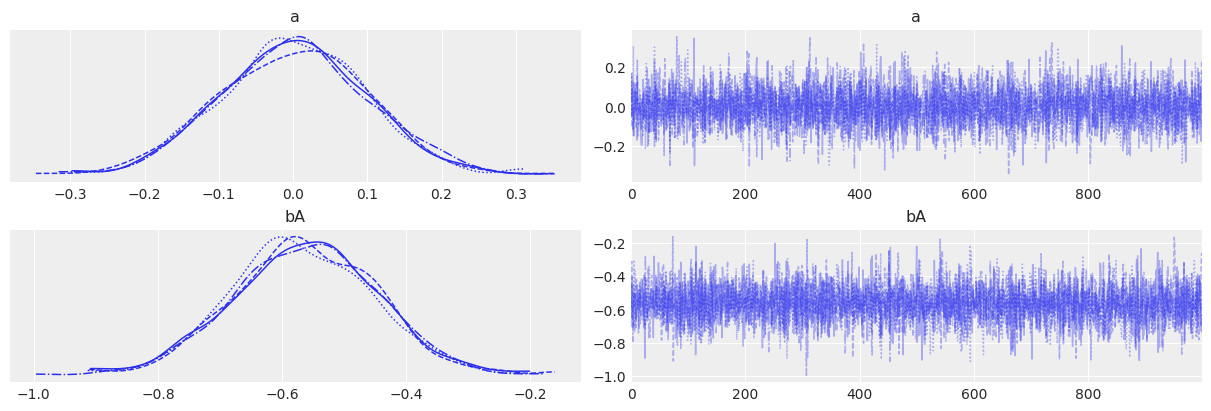

In [11]:
az.plot_trace(m_5_1_trace, var_names=["a", "bA"]);

#### Code 5.4

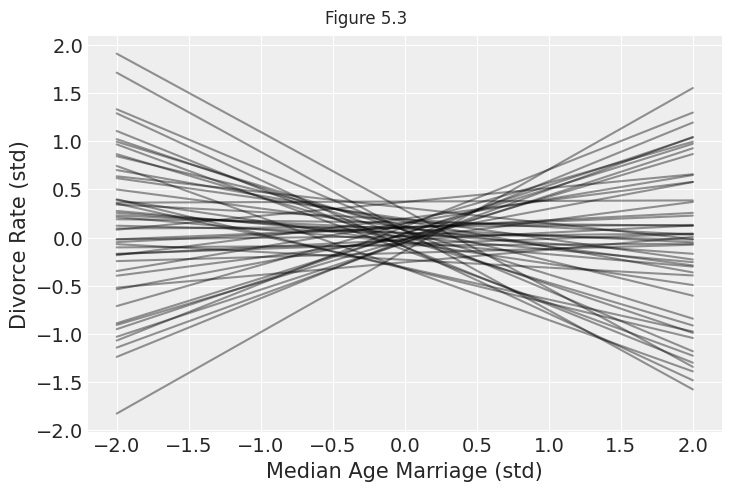

In [12]:
fig, ax = plt.subplots()

x = np.linspace(-2, 2, 50)

prior_samp_a = np.array(az.extract_dataset(prior_samples["prior"])["a"][:50])
prior_samp_bA = np.array(az.extract_dataset(prior_samples["prior"])["bA"][:50])

for a, ba in zip(prior_samp_a, prior_samp_bA):
    y = a + ba * x
    ax.plot(x, y, c="black", alpha=0.4)

ax.set_xlabel("Median Age Marriage (std)")
ax.set_ylabel("Divorce Rate (std)")
fig.suptitle("Figure 5.3");

#### Code 5.5

In [13]:
m_5_1_trace.posterior["bA"].shape

(4, 1000)

In [14]:
# This is equivalent of link function

age_std_seq = np.linspace(-3, 3.2, 30)

# Given that we have a lot of samples we can use less of them for plotting (or we can use all!)
# m_5_1_trace = m_5_1_trace.sel(draw=slice(None, None, 10))
m_5_1_data = az.extract_dataset(m_5_1_trace.posterior)

mu_pred = np.zeros((len(age_std_seq), len(m_5_1_data.sample)))

for i, age_std in enumerate(age_std_seq):
    mu_pred[i] = m_5_1_data["a"] + m_5_1_data["bA"] * age_std

In [15]:
m_5_1_data.to_dataframe()

a        bA     sigma        mu  chain  draw
chain draw mu_dim_0                                                     
0     0    0         0.079746 -0.629511  0.784133  0.461413      0     0
           1         0.079746 -0.629511  0.784133  0.512031      0     0
           2         0.079746 -0.629511  0.784133  0.208318      0     0
           3         0.079746 -0.629511  0.784133  0.967601      0     0
           4         0.079746 -0.629511  0.784133 -0.297870      0     0
...                       ...       ...       ...       ...    ...   ...
3     999  45       -0.036231 -0.627626  0.694588 -0.210848      3   999
           46       -0.036231 -0.627626  0.694588  0.041489      3   999
           47       -0.036231 -0.627626  0.694588  0.495694      3   999
           48       -0.036231 -0.627626  0.694588 -0.160380      3   999
           49       -0.036231 -0.627626  0.694588  0.899431      3   999

[200000 rows x 6 columns]

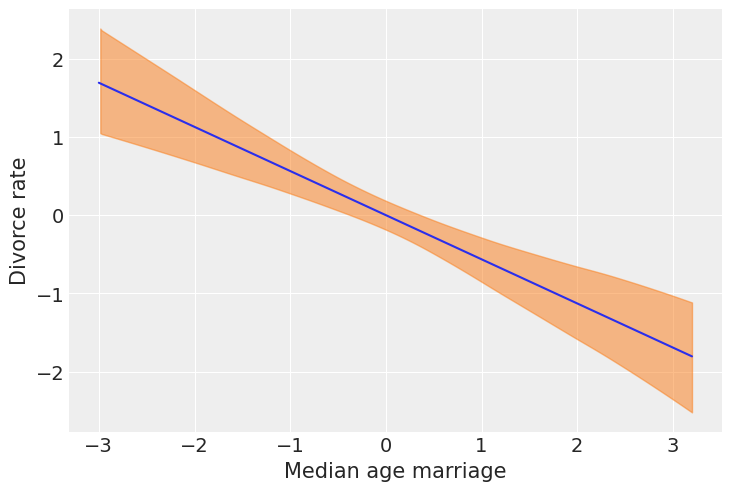

In [16]:
# Now I need to take average of mu and plot
# I should get 30 averages, one for each x
mu_mean = mu_pred.mean(axis=1)

# This is equivalent of Percent Interval
ax = az.plot_hdi(age_std_seq, mu_pred.T)
plt.plot(age_std_seq, mu_mean)
ax.set_xlabel("Median age marriage")
ax.set_ylabel("Divorce rate");

#### 5.6

In [17]:
with pm.Model() as m_5_2:
    a = pm.Normal("a", 0, 0.2)
    bM = pm.Normal("bM", 0, 0.5)
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic("mu", a + bM * data["Marriage_std"].values)

    divorce_rate_std = pm.Normal(
        "divorce_rate_std", mu=mu, sigma=sigma, observed=data["Divorce_std"].values
    )
    prior_samples = pm.sample_prior_predictive()
    m_5_2_trace = pm.sample()

Sampling: [a, bM, divorce_rate_std, sigma]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bM, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


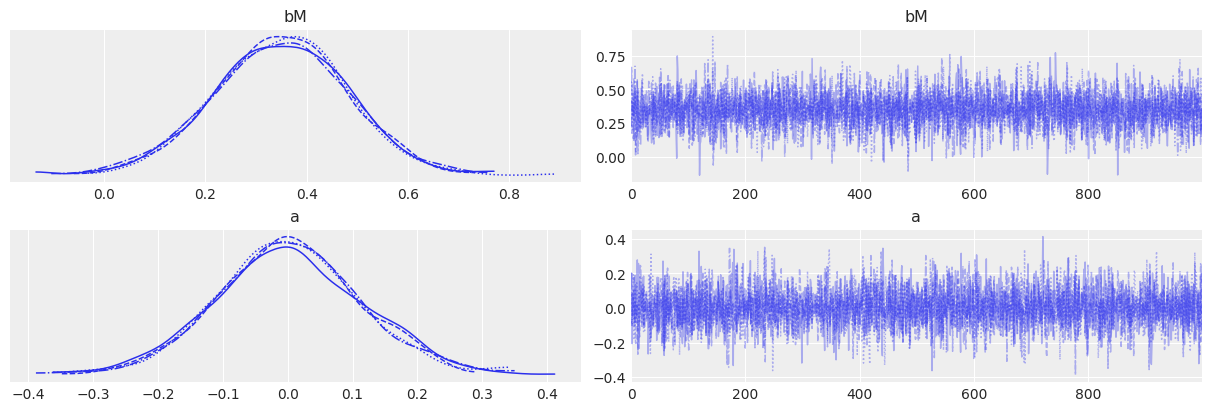

In [18]:
az.plot_trace(m_5_2_trace, var_names=["bM", "a"]);

#### 5.7
Credit to [ksachdeva](https://ksachdeva.github.io/rethinking-tensorflow-probability/05_the_many_variables_and_the_spurious_waffles#Code-5.7)


Author suggests that merely comparing parameter means between bivariate regressions is no way to decide which predictor is better. They may be independent, or related or could eliminate each other. 

How do we understand all this ?

He explains that here we may want to think **causally**. 

Few interesting assumptions (or rather deductions) -

* a) Age has a direct impact on Divorce rate as people may grow incompatible with the parter 

* b) Marriage Rate has a direct impact on Divorce rate for obvious reason (more marriages => more divorce)

* c) Finally, Age has an impact on Marriage Rate because there are more young people

Another way to represent above is :

A -> D

M -> D

A -> M

and yet another way is to use **DAG** (Directed Acyclic Graphs)


/usr/local/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  func(*args, **kwargs)
/usr/local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


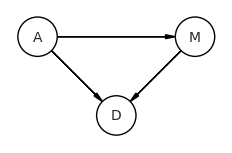

In [19]:
dag5_1 = CausalGraphicalModel(nodes=["A", "D", "M"], edges=[("A", "D"), ("A", "M"), ("M", "D")])
pgm = daft.PGM()
coordinates = {"A": (0, 0), "D": (1, 1), "M": (2, 0)}
for node in dag5_1.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag5_1.dag.edges:
    pgm.add_edge(*edge)
pgm.render()
plt.gca().invert_yaxis()

Above DAG clearly shows that A impacts D directly and indirectly (i.e. via M)

The author used "total influence". What is meant by *total* is that we need to account for every path from **A** to **D**.

**MEDIATION** - Let's say that **A** did not directly influence **D**; rather it did it via **M**. This type of relationship is called *Mediation*


Author raises many interesting questions here. He asks if there is indeed a direct effect of marriage rate or rather is age at marriage just driving both, creating a **spurious** correlation between marriage rate and divorce rate


#### 5.8

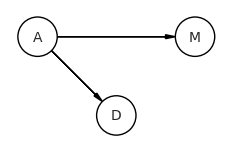

In [20]:
# Note - There is no explicit code section for drawing the second DAG
# but the figure appears in the book and hence drawing it as well
dag5_2 = CausalGraphicalModel(nodes=["A", "D", "M"], edges=[("A", "D"), ("A", "M")])
pgm = daft.PGM()
coordinates = {"A": (0, 0), "D": (1, 1), "M": (2, 0)}
for node in dag5_2.dag.nodes:
    pgm.add_node(node, node, *coordinates[node])
for edge in dag5_2.dag.edges:
    pgm.add_edge(*edge)
pgm.render()
plt.gca().invert_yaxis()

We can get the joint probability distribution implied by our causal graphical model using

In [21]:
print(dag5_2.get_distribution())

P(A)P(D|A)P(M|A)


To see the Conditional Independencies, we can use one of the following two snippets. The explanation is that **M** and **D** are not independent, unless we condition on **A** when they become conditionally independent.

In [22]:
dag5_2.get_all_independence_relationships()

[('M', 'D', {'A'})]

In [23]:
DMA_dag2 = CausalGraphicalModel(nodes=["A", "D", "M"], edges=[("A", "D"), ("A", "M")])
all_independencies = DMA_dag2.get_all_independence_relationships()
for s in all_independencies:
    if all(
        t[0] != s[0] or t[1] != s[1] or not t[2].issubset(s[2])
        for t in all_independencies
        if t != s
    ):
        print(s)

('M', 'D', {'A'})


#### 5.9

Checking the independencies in the first DAG

In [24]:
DMA_dag1 = CausalGraphicalModel(nodes=["A", "D", "M"], edges=[("A", "D"), ("A", "M"), ("M", "D")])
all_independencies = DMA_dag1.get_all_independence_relationships()
for s in all_independencies:
    if all(
        t[0] != s[0] or t[1] != s[1] or not t[2].issubset(s[2])
        for t in all_independencies
        if t != s
    ):
        print(s)

Executing above cell should not display anything as in the DAG1 (where all nodes are connected to each other) there are no conditional independencies.

#### 5.10

In [25]:
with pm.Model() as m_5_3:
    a = pm.Normal("a", 0, 0.2)
    bA = pm.Normal("bA", 0, 0.5)
    bM = pm.Normal("bM", 0, 0.5)

    sigma = pm.Exponential("sigma", 1)
    mu = pm.Deterministic(
        "mu", a + bM * data["Marriage_std"].values + bA * data["MedianAgeMarriage_std"].values
    )

    divorce_rate_std = pm.Normal(
        "divorce_rate_std", mu=mu, sigma=sigma, observed=data["Divorce_std"].values
    )
    prior_samples = pm.sample_prior_predictive()
    m_5_3_trace = pm.sample()

Sampling: [a, bA, bM, divorce_rate_std, sigma]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bA, bM, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [26]:
az.summary(m_5_3_trace, var_names=["a", "bM", "bA", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.001,0.099,-0.181,0.190,0.002,0.002,3225.0,2569.0,1.0
bM,-0.065,0.158,-0.348,0.250,0.003,0.002,3006.0,2769.0,1.0
bA,-0.611,0.158,-0.923,-0.329,0.003,0.002,2925.0,2785.0,1.0
sigma,0.825,0.086,0.676,0.986,0.001,0.001,3365.0,2541.0,1.0


#### 5.11

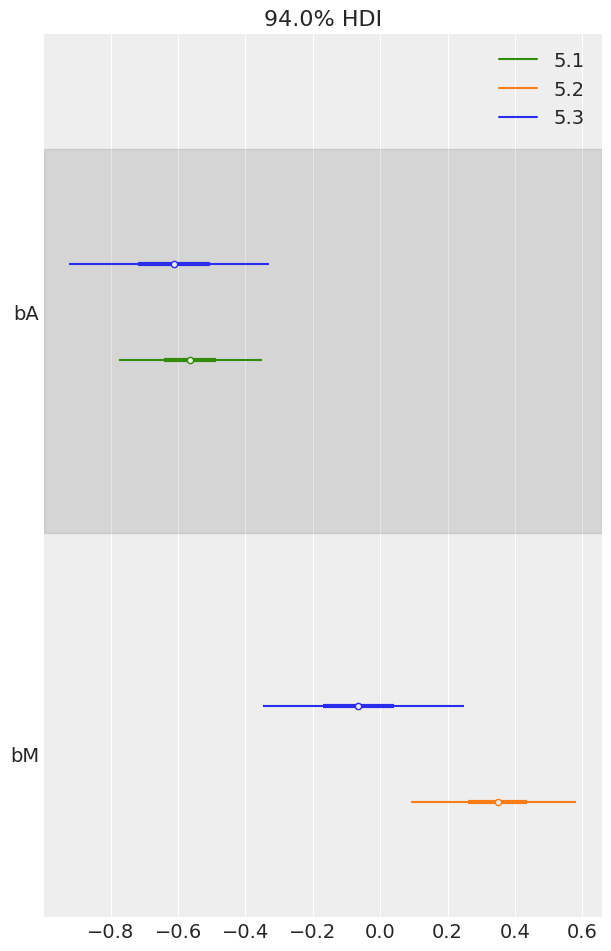

In [27]:
az.plot_forest(
    [
        m_5_3_trace,
        m_5_2_trace,
        m_5_1_trace,
    ],
    model_names=["5.3", "5.2", "5.1"],
    var_names=["bA", "bM"],
    combined=True,
);

#### 5.12

In [28]:
N = 50
age = stats.norm().rvs(N)
mar = stats.norm(-age).rvs(N)
div = stats.norm(age).rvs(N)

#### 5.13

In [29]:
with pm.Model() as m_5_4:
    a = pm.Normal("a", 0, 0.2)
    bAM = pm.Normal("bAM", 0, 0.5)
    sigma = pm.Exponential("sigma", 1)

    mu = pm.Deterministic("mu", a + bAM * data["MedianAgeMarriage_std"].values)

    marriage_std = pm.Normal(
        "Marriage_std", mu=mu, sigma=sigma, observed=data["Marriage_std"].values
    )
    prior_samples = pm.sample_prior_predictive()
    m_5_4_trace = pm.sample()

Sampling: [Marriage_std, a, bAM, sigma]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, bAM, sigma]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


#### 5.14

In [30]:
mu_m_5_4_mean = m_5_4_trace.posterior["mu"].mean(dim=["chain", "draw"])
residuals = data["Marriage_std"] - mu_m_5_4_mean

#### 5.15
We can skip most of the code with the posterior predictive plot functionality in pymc

In [31]:
with m_5_3:
    m_5_3_ppc = pm.sample_posterior_predictive(m_5_3_trace, var_names=["mu", "divorce_rate_std"])


mu_mean = m_5_3_ppc.posterior_predictive["mu"].mean(dim=["chain", "draw"])
mu_PI = az.hdi(m_5_3_ppc.posterior_predictive["mu"], 0.89)

D_sim = m_5_3_ppc.posterior_predictive["divorce_rate_std"].mean(dim=["chain", "draw"])
D_PI = az.hdi(m_5_3_ppc.posterior_predictive["divorce_rate_std"], 0.89)

Sampling: [divorce_rate_std]


#### 5.16

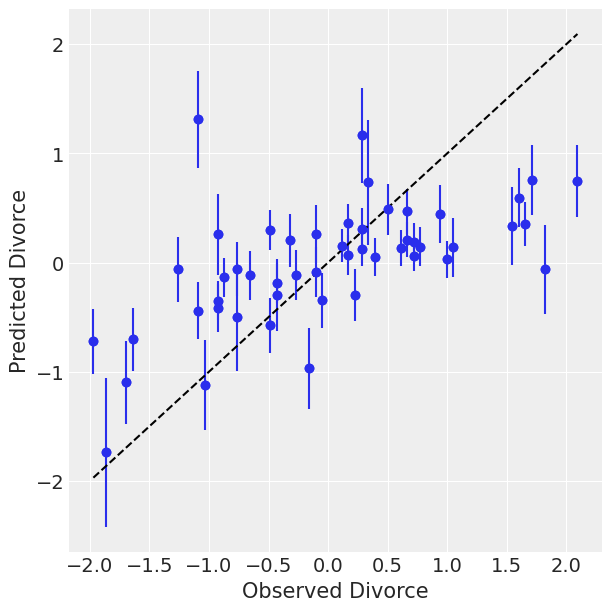

In [32]:
fig, ax = plt.subplots(figsize=(6, 6))
plt.errorbar(
    data["Divorce_std"].values,
    D_sim,
    yerr=np.abs(np.array(D_sim) - mu_PI.min(dim="hdi").to_array()),
    fmt="C0o",
)
ax.scatter(data["Divorce_std"].values, D_sim)

min_x, max_x = data["Divorce_std"].min(), data["Divorce_std"].max()
ax.plot([min_x, max_x], [min_x, max_x], "k--")

ax.set_ylabel("Predicted Divorce")
ax.set_xlabel("Observed Divorce");

#### 5.17

#### 5.18

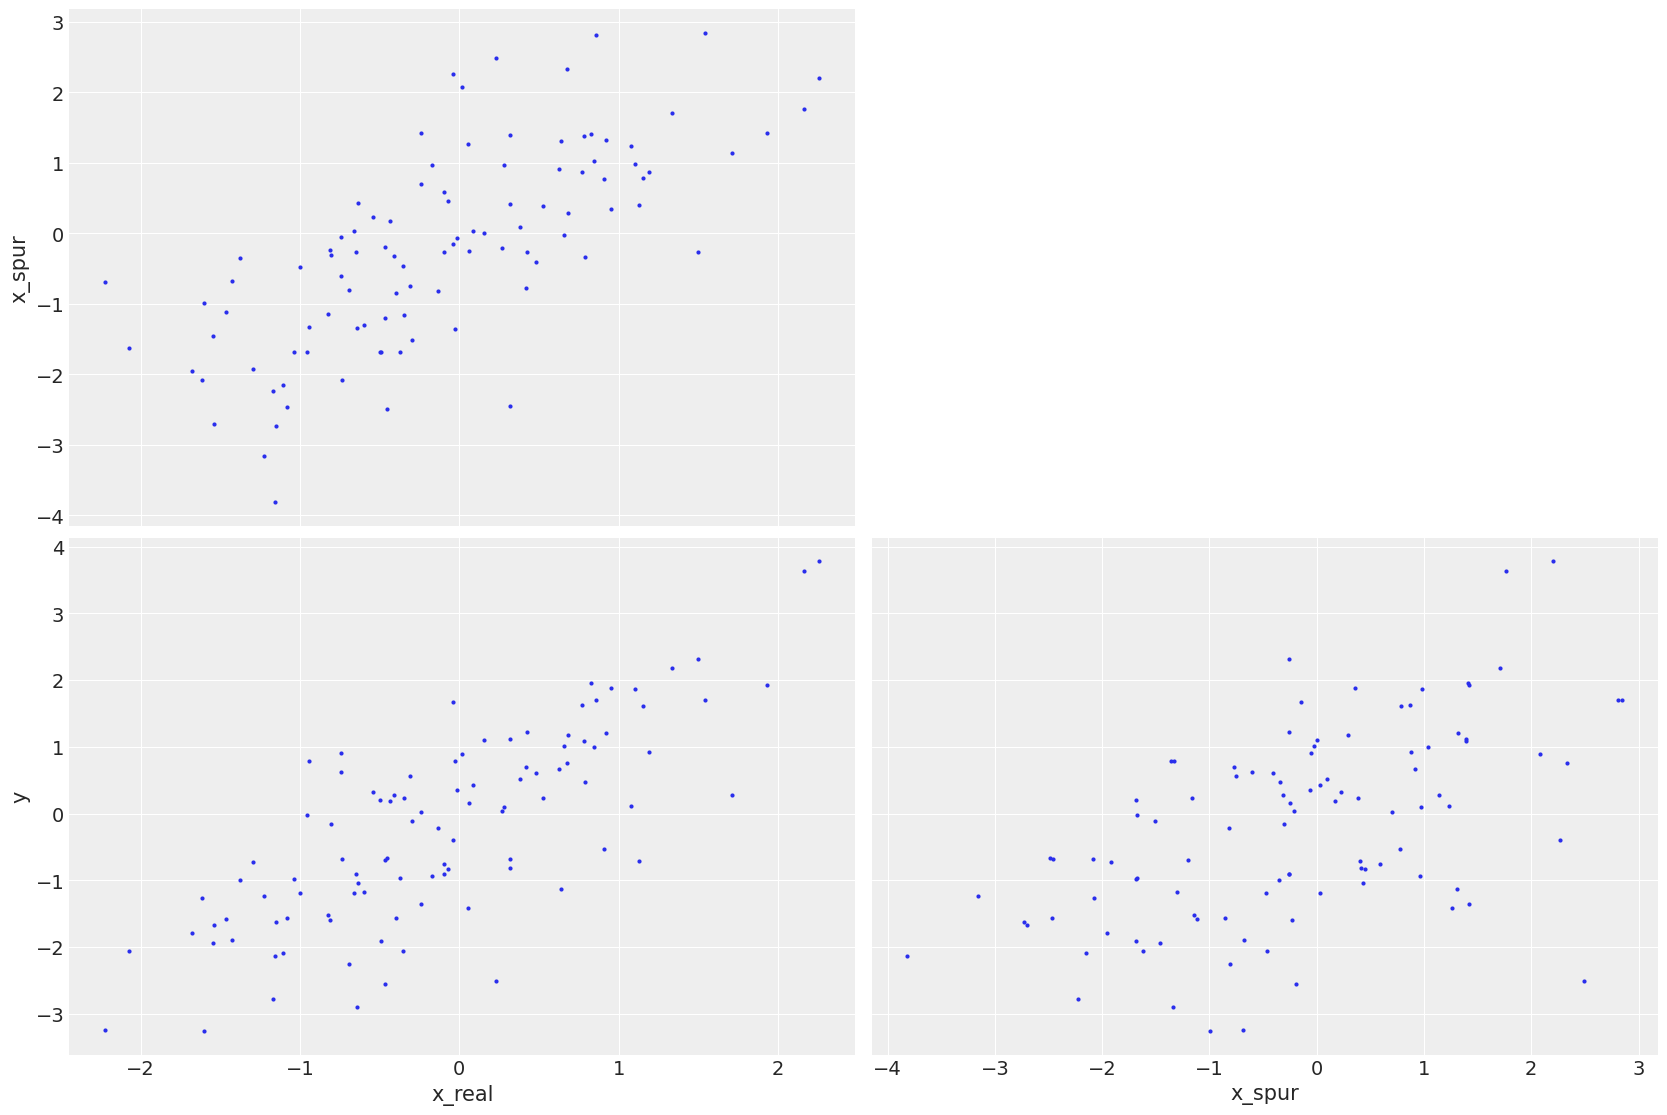

In [33]:
N = 100
x_real = stats.norm.rvs(size=N)
x_spur = stats.norm.rvs(x_real)
y = stats.norm.rvs(x_real)

az.plot_pair({"x_real": x_real, "x_spur": x_spur, "y": y});

#### 5.19

In [34]:
data["Divorce_std"] = standardize(data["Divorce"])
data["Marriage_std"] = standardize(data["Marriage"])
data["MedianAgeMarriage_std"] = standardize(data["MedianAgeMarriage"])


with pm.Model() as m5_3_A:
    # Use ~Aesara shared~ MutableData variables so we can change them later
    marriage_x = pm.MutableData('marriage_x', data["Marriage_std"].values)
    age_x = pm.MutableData('age_x', data["MedianAgeMarriage_std"].values)

    # A -> D <- M
    sigma = pm.Exponential("sigma", 1)
    bA = pm.Normal("b_age", 0, 0.5)
    bM = pm.Normal("b_marriage_rate", 0, 0.5)

    a = pm.Normal("a", 0, 0.2)
    mu = pm.Deterministic("mu", a + bA * age_x + bM * marriage_x)
    divorce = pm.Normal("divorce", mu, sigma, observed=data["Divorce_std"].values)

    # A -> M
    sigma_M = pm.Exponential("sigma_m", 1)
    bAM = pm.Normal("b_age_on_marriate_rate", 0, 0.5)
    aM = pm.Normal("aM", 0, 0.2)
    mu_M = pm.Deterministic("mu_m", aM + bAM * age_x)
    marriage = pm.Normal("marriage", mu_M, sigma_M, observed=data["Marriage_std"].values)

    m5_3_A_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b_age, b_marriage_rate, a, sigma_m, b_age_on_marriate_rate, aM]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


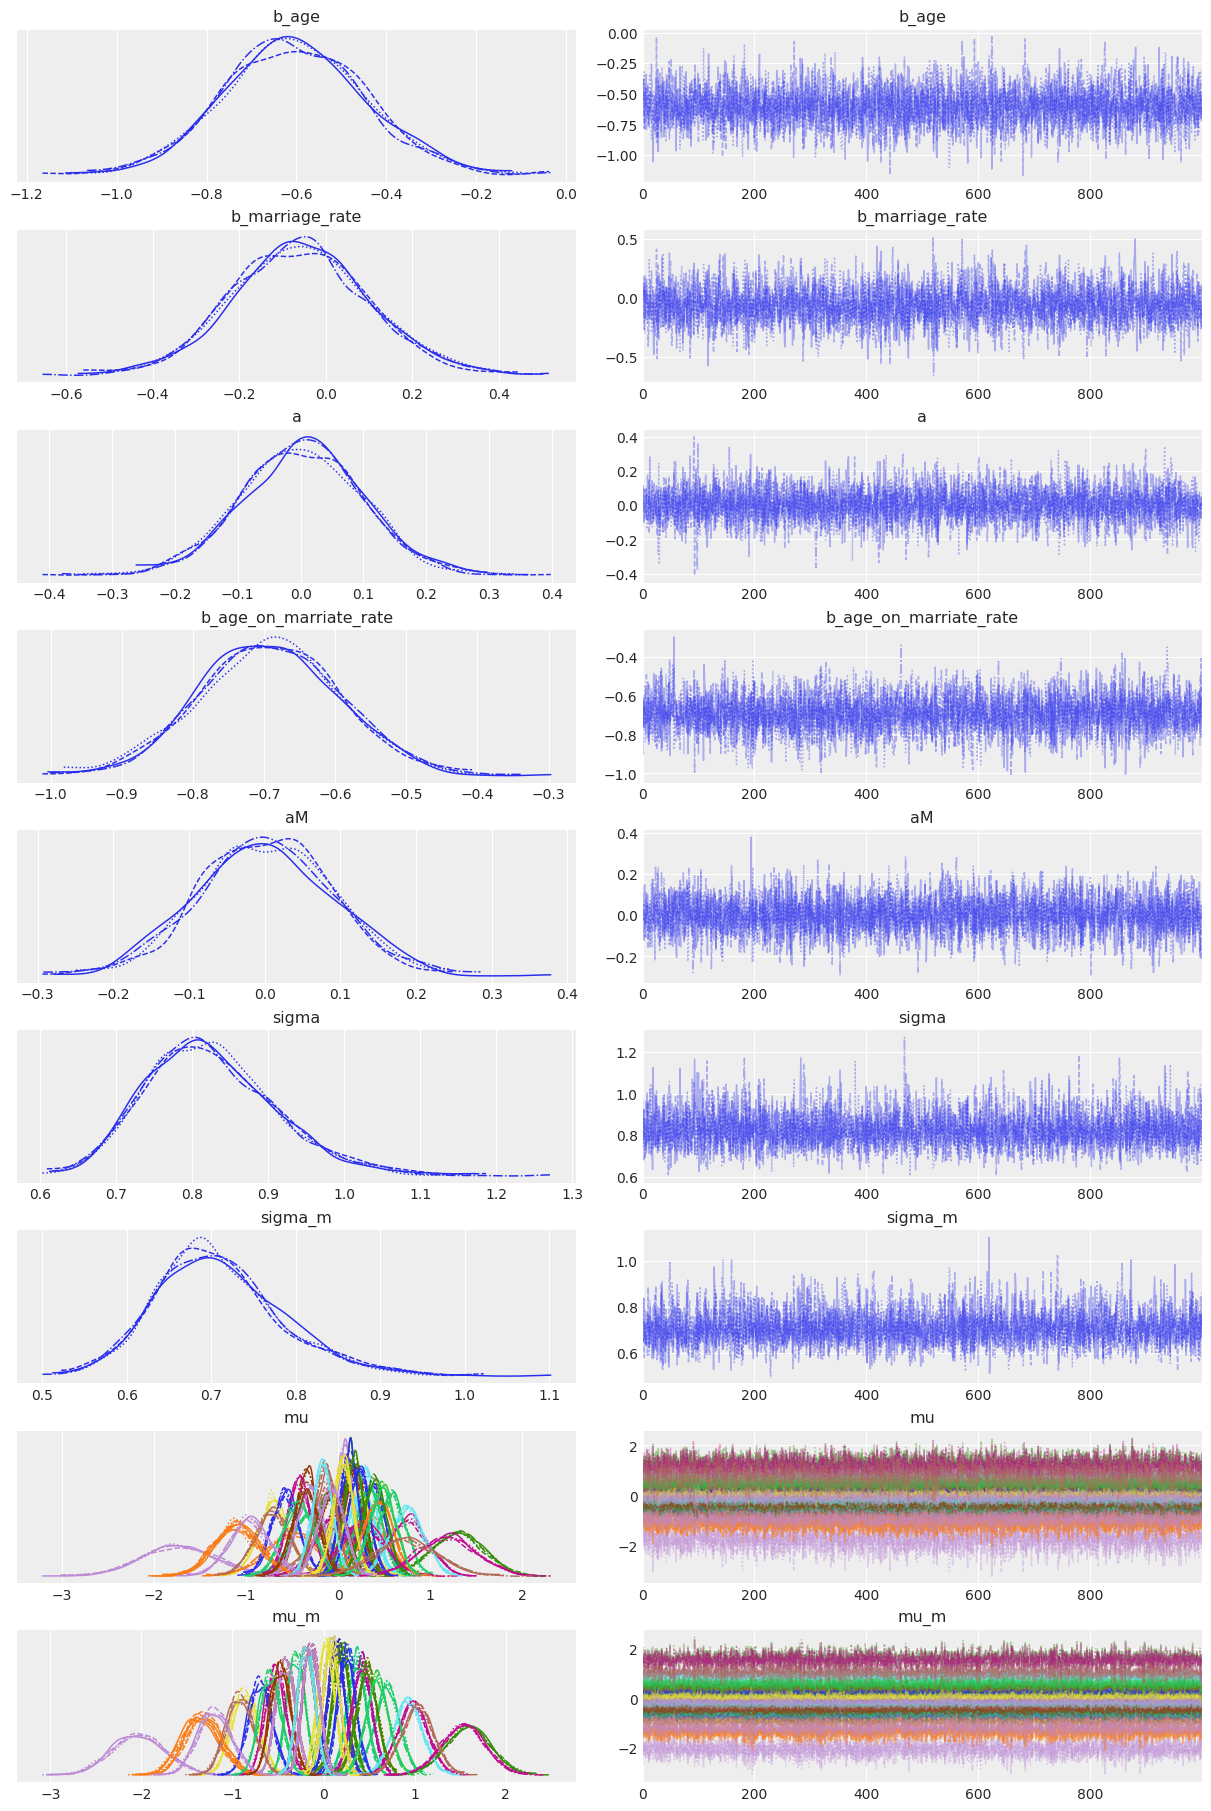

In [35]:
az.plot_trace(m5_3_A_trace);

#### 5.20

In [36]:
# We're setting this to 50 to **match the shape of our input**
age_seq = np.linspace(-2, 2, 50)
print(age_seq.shape)
print(age_seq)

(50,)
[-2.         -1.91836735 -1.83673469 -1.75510204 -1.67346939 -1.59183673
 -1.51020408 -1.42857143 -1.34693878 -1.26530612 -1.18367347 -1.10204082
 -1.02040816 -0.93877551 -0.85714286 -0.7755102  -0.69387755 -0.6122449
 -0.53061224 -0.44897959 -0.36734694 -0.28571429 -0.20408163 -0.12244898
 -0.04081633  0.04081633  0.12244898  0.20408163  0.28571429  0.36734694
  0.44897959  0.53061224  0.6122449   0.69387755  0.7755102   0.85714286
  0.93877551  1.02040816  1.10204082  1.18367347  1.26530612  1.34693878
  1.42857143  1.51020408  1.59183673  1.67346939  1.75510204  1.83673469
  1.91836735  2.        ]


#### 5.21

In [37]:
# With PyMC we have to simulate in each model separately
# Simulate the marriage rates at each age first

with m5_3_A:
    age_x.set_value(age_seq)
    m5_3_M_marriage = pm.sample_posterior_predictive(m5_3_A_trace)

Sampling: [divorce, marriage]


In [38]:
m5_3_M_marriage

Inference data with groups:
	> posterior_predictive
	> observed_data
	> constant_data

#### 5.22

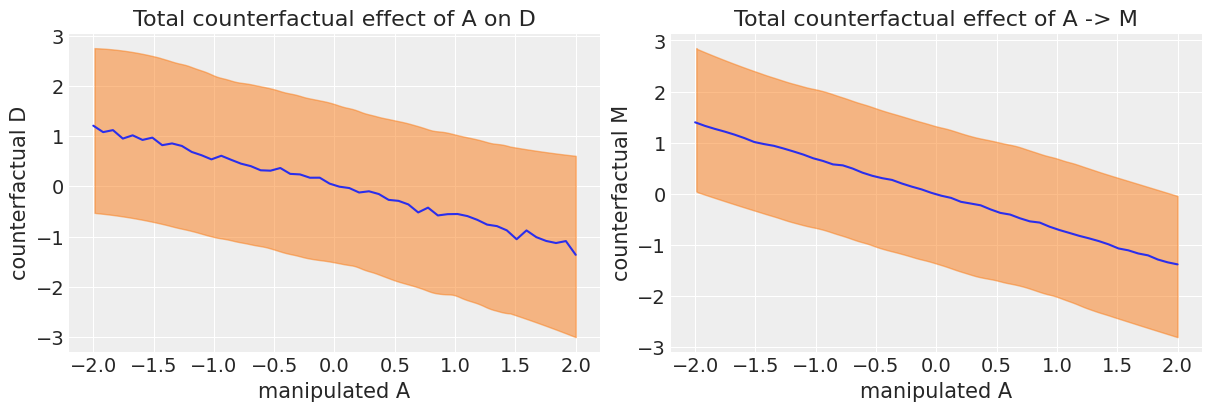

In [39]:
_, ax = plt.subplots(1, 2, figsize=(12, 4))
az.plot_hdi(age_seq, m5_3_M_marriage.posterior_predictive["divorce"], ax=ax[0])
ax[0].plot(age_seq, m5_3_M_marriage.posterior_predictive["divorce"].mean(dim=["chain", "draw"]))
ax[0].set_title("Total counterfactual effect of A on D")
ax[0].set_xlabel("manipulated A")
ax[0].set_ylabel("counterfactual D")


az.plot_hdi(age_seq, m5_3_M_marriage.posterior_predictive["marriage"], ax=ax[1])
ax[1].plot(age_seq, m5_3_M_marriage.posterior_predictive["marriage"].mean(dim=["chain", "draw"]))
ax[1].set_title("Total counterfactual effect of A -> M")
ax[1].set_xlabel("manipulated A")
ax[1].set_ylabel("counterfactual M");

#### 5.23

In [40]:
# We're setting this to 50 to match the shape of our input
age_seq = (np.linspace(20, 30, 50) - 26.1) / 1.24
age_seq

array([-4.91935484, -4.75477288, -4.59019092, -4.42560895, -4.26102699,
       -4.09644503, -3.93186307, -3.76728111, -3.60269914, -3.43811718,
       -3.27353522, -3.10895326, -2.9443713 , -2.77978934, -2.61520737,
       -2.45062541, -2.28604345, -2.12146149, -1.95687953, -1.79229756,
       -1.6277156 , -1.46313364, -1.29855168, -1.13396972, -0.96938776,
       -0.80480579, -0.64022383, -0.47564187, -0.31105991, -0.14647795,
        0.01810402,  0.18268598,  0.34726794,  0.5118499 ,  0.67643186,
        0.84101382,  1.00559579,  1.17017775,  1.33475971,  1.49934167,
        1.66392363,  1.8285056 ,  1.99308756,  2.15766952,  2.32225148,
        2.48683344,  2.6514154 ,  2.81599737,  2.98057933,  3.14516129])

In [41]:
with m5_3_A:
    age_x.set_value(age_seq)
    m5_3_M_ppc = pm.sample_posterior_predictive(m5_3_A_trace)

# Average first and last column and take difference
(
    m5_3_M_ppc.posterior_predictive["divorce"][:, -1].mean()
    - m5_3_M_ppc.posterior_predictive["divorce"][:, 0].mean()
)

Sampling: [divorce, marriage]


<xarray.DataArray 'divorce' ()>
array(0.21700634)

#### 5.24

In [42]:
# Set values for marriage counterfactual
marriage_counter_factual_x = np.linspace(-2, 2, 50)
marriage_x.set_value(marriage_counter_factual_x)

# Fix age to zero
age_x.set_value(np.zeros(50))

with m5_3_A:
    m5_3_M_ppc = pm.sample_posterior_predictive(m5_3_A_trace)

Sampling: [divorce, marriage]


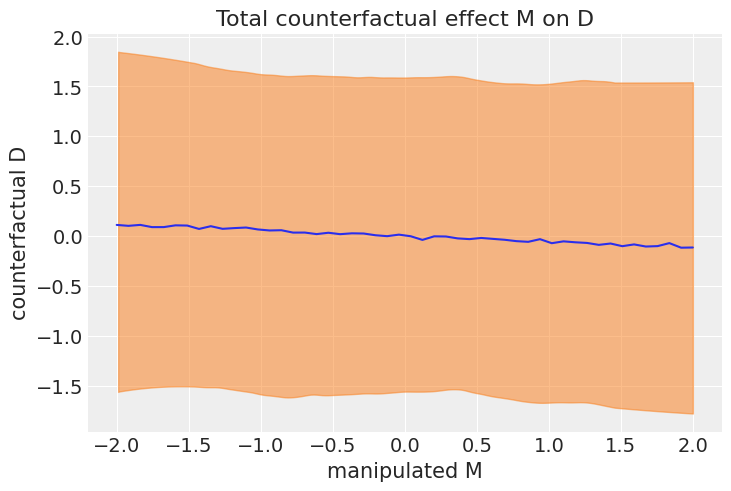

In [43]:
fig, ax = plt.subplots()

az.plot_hdi(marriage_counter_factual_x, m5_3_M_ppc.posterior_predictive["divorce"], ax=ax)
ax.plot(
    marriage_counter_factual_x,
    m5_3_M_ppc.posterior_predictive["divorce"].mean(dim=["chain", "draw"]),
)
ax.set_title("Total counterfactual effect M on D")
ax.set_xlabel("manipulated M")
ax.set_ylabel("counterfactual D");

#### 5.25

In [44]:
A_seq = np.linspace(-2, 2, 30)

#### 5.26

In [46]:
# Get the samples from Age Marriage model first
with m5_3_A:
    m5_3_M_marriage = pm.sample_posterior_predictive(
        m5_3_A_trace, var_names=["sigma_m", "aM", "b_age_on_marriate_rate"]
    )

Sampling: [aM, b_age_on_marriate_rate, sigma_m]


In [47]:
marriage_mu_counterfactual = np.outer(
    m5_3_M_marriage.posterior_predictive["aM"] + m5_3_M_marriage.posterior_predictive["b_age_on_marriate_rate"], A_seq
)
marriage_mu_counterfactual.shape

(4000, 30)

In [48]:
mu = marriage_mu_counterfactual.T
sigma = az.extract_dataset(m5_3_M_marriage.posterior_predictive["sigma_m"]).to_array()
M_sim = stats.norm(loc=mu, scale=sigma).rvs()
M_sim.shape

(30, 4000)

#### 5.27

In [49]:
with m5_3_A:
    m5_3_M_divorce = pm.sample_posterior_predictive(
        m5_3_A_trace, var_names=["sigma", "b_marriage_rate", "b_age", "a"]
    )

Sampling: [a, b_age, b_marriage_rate, sigma]


In [50]:
D_sim = np.zeros((30, 4000))
a = np.array(az.extract_dataset(m5_3_M_divorce.posterior_predictive["a"]).to_array())
bM = np.array(az.extract_dataset(m5_3_M_divorce.posterior_predictive["b_marriage_rate"]).to_array())
bA = np.array(az.extract_dataset(m5_3_M_divorce.posterior_predictive["b_age"]).to_array())
sigma = np.array(az.extract_dataset(m5_3_M_divorce.posterior_predictive["sigma"]).to_array())

for i, age_counterfactual in enumerate(A_seq):
    divorce_mu_counterfactual = a + bA * age_counterfactual + bM * M_sim[i, :]
    samples = stats.norm(divorce_mu_counterfactual, sigma).rvs()
    D_sim[i, :] = samples

#### 5.28

In [52]:
d = pd.read_csv('/code/data/milk.csv', delimiter=";")
d.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN


#### 5.29

In [53]:
d["K"] = standardize(d["kcal.per.g"])
d["N"] = standardize(d["neocortex.perc"])
d["M"] = standardize(d["mass"])

#### 5.30

In [54]:
# This is meant to fail!
with pm.Model() as m5_5_draft:
    sigma = pm.Exponential("sigma", 1)
    bN = pm.Normal("bN", 0, 1)
    a = pm.Normal("a", 0, 1)
    mu = pm.Deterministic("mu", a + bN * d["N"].values)

    K = pm.Normal("K", mu, sigma, observed=d["K"].values)

    m5_5_draft_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


SamplingError: Initial evaluation of model at starting point failed!
Starting values:
{'sigma_log__': array(0.50075652), 'bN': array(-0.65515137), 'a': array(0.62370439)}

Initial evaluation results:
{'sigma': -1.15, 'bN': -1.13, 'a': -1.11, 'K': nan}

#### 5.32

In [56]:
d["neocortex.perc"]

0     55.16
1       NaN
2       NaN
3       NaN
4       NaN
5     64.54
6     64.54
7     67.64
8       NaN
9     68.85
10    58.85
11    61.69
12    60.32
13      NaN
14      NaN
15    69.97
16      NaN
17    70.41
18      NaN
19    73.40
20      NaN
21    67.53
22      NaN
23    71.26
24    72.60
25      NaN
26    70.24
27    76.30
28    75.49
Name: neocortex.perc, dtype: float64

#### 5.32

In [57]:
dcc = d.dropna(axis=0)
dcc.shape

(17, 11)

#### 5.33

In [59]:
with pm.Model() as m5_5_draft:
    shared_N = pm.MutableData('N_x', dcc["N"].values)


    sigma = pm.Exponential("sigma", 1)
    bN = pm.Normal("bN", 0, 1)
    a = pm.Normal("a", 0, 1)
    mu = pm.Deterministic("mu", a + bN * shared_N)

    K = pm.Normal("K", mu, sigma, observed=dcc["K"])

    m5_5_draft_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, bN, a]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


#### 5.34

In [61]:
xseq = [-2, 2]
with m5_5_draft:
    shared_N.set_value(np.array(xseq))
    m5_5_draft_prior_predictive = pm.sample_prior_predictive()

Sampling: [K, a, bN, sigma]


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (17,) and arg 1 with shape (2,).
Apply node that caused the error: normal_rv{0, (0, 0), floatX, True}(RandomGeneratorSharedVariable(<Generator(PCG64) at 0xFFFF56C93300>), TensorConstant{(1,) of 17}, TensorConstant{11}, mu, sigma)
Toposort index: 6
Inputs types: [RandomGeneratorType, TensorType(int64, (1,)), TensorType(int64, ()), TensorType(float64, (?,)), TensorType(float64, ())]
Inputs shapes: ['No shapes', (1,), (), (2,), ()]
Inputs strides: ['No strides', (8,), (), (8,), ()]
Inputs values: [Generator(PCG64) at 0xFFFF56C93300, array([17]), array(11), array([-0.2071604 , -2.70660463]), array(0.00414139)]
Outputs clients: [['output'], ['output']]

HINT: Re-running with most PyTensor optimizations disabled could provide a back-trace showing when this node was created. This can be done by setting the PyTensor flag 'optimizer=fast_compile'. If that does not work, PyTensor optimizations can be disabled with 'optimizer=None'.
HINT: Use the PyTensor flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.

In [ ]:
fig, ax = plt.subplots()

ppr_K = m5_5_draft_prior_predictive.prior_predictive["K"].mean(dim=["chain"])

for i in range(50):
    ax.plot(xseq, ppr_K[i], c="black", alpha=0.3)
ax.set_xlim(xseq)
ax.set_ylim(xseq)
ax.set_title("a~dnorm(0,1) \n bN~dnorm(0,1)")
ax.set_xlabel("neocortex percent (std)")
ax.set_ylabel("kilocal per g (std)");

#### 5.35

In [ ]:
shared_N = shared(dcc["N"].values)

with pm.Model() as m5_5:
    sigma = pm.Exponential("sigma", 1)
    bN = pm.Normal("bN", 0, 0.5)
    a = pm.Normal("a", 0, 0.2)
    mu = pm.Deterministic("mu", a + bN * shared_N)

    K = pm.Normal("K", mu, sigma, observed=dcc["K"])

    m5_5_trace = pm.sample()

m5_5_data = az.extract_dataset(m5_5_trace)

In [ ]:
xseq = [-2, 2]
shared_N.set_value(np.array(xseq))
with m5_5:
    m5_5_prior_predictive = pm.sample_prior_predictive()

In [ ]:
fig, ax = plt.subplots()

ppr_K = m5_5_prior_predictive.prior_predictive["K"].mean(dim=["chain"])

for i in range(50):
    ax.plot(xseq, ppr_K[i], c="black", alpha=0.3)
ax.set_xlim(xseq)
ax.set_ylim(xseq)
ax.set_title("a~dnorm(0,1) \n bN~dnorm(0,1)")
ax.set_xlabel("neocortex percent (std)")
ax.set_ylabel("kilocal per g (std)");

#### 5.36

In [ ]:
az.summary(m5_5_trace, var_names=["a", "bN", "sigma"])

#### 5.37

In [ ]:
xseq = np.linspace(dcc["N"].min() - 0.15, dcc["N"].max() + 0.15, 30)

shared_N.set_value(xseq)

with m5_5:
    m5_5_posterior_predictive = pm.sample_posterior_predictive(m5_5_trace, var_names=["mu"])

mu_ppd = m5_5_posterior_predictive.posterior_predictive["mu"]
mu_mean = mu_ppd.mean(dim=["chain", "draw"])

fig, ax = plt.subplots()
az.plot_hdi(xseq, mu_ppd, ax=ax)
ax.plot(xseq, mu_mean, c="black")
ax.scatter(dcc["N"], dcc["K"], facecolors="none", edgecolors="b")
ax.set_ylim(-1.5, 2.2)
ax.set_xlabel("neocortex percent (std)")
ax.set_ylabel("kilocal per g (std)");

#### 5.38

In [ ]:
shared_M = shared(dcc["M"].values)

with pm.Model() as m5_6:
    sigma = pm.Exponential("sigma", 1)
    bM = pm.Normal("bM", 0, 0.5)
    a = pm.Normal("a", 0, 0.2)
    mu = pm.Deterministic("mu", a + bM * shared_M)

    K = pm.Normal("K", mu, sigma, observed=dcc["K"])

    m5_6_trace = pm.sample()

m5_6_data = az.extract_dataset(m5_6_trace)
az.summary(m5_6_trace, var_names=["bM", "a", "sigma"])

#### 5.39

In [ ]:
shared_N = shared(dcc["N"].values)
shared_M = shared(dcc["M"].values)

with pm.Model() as m5_7:
    sigma = pm.Exponential("sigma", 1)
    bN = pm.Normal("bN", 0, 0.5)
    bM = pm.Normal("bM", 0, 0.5)
    a = pm.Normal("a", 0, 0.2)

    mu = pm.Deterministic("mu", a + bN * shared_N + bM * shared_M)

    K = pm.Normal("K", mu, sigma, observed=dcc["K"])

    m5_7_trace = pm.sample(tune=2000, draws=10000)

m5_7_data = az.extract_dataset(m5_7_trace)
az.summary(m5_7_trace, var_names=["a", "bN", "bM", "sigma"])

#### 5.40

In [ ]:
az.plot_forest(
    [m5_7_trace, m5_6_trace, m5_5_trace],
    model_names=["m5.7", "m5.6", "m5.5"],
    var_names=["bM", "bN"],
    combined=True,
);

#### 5.41
This code actually produces right plot Confirned from Professor McElreath that the book text is mistaken.

In [ ]:
xseq = np.linspace(dcc["M"].min() - 0.15, dcc["M"].max() + 0.15, 30)
shared_N.set_value(np.zeros(30))
shared_M.set_value(xseq)


with m5_7:
    m5_7_posterior_predictive = pm.sample_posterior_predictive(m5_7_trace, var_names=["mu"])

mu_ppd = m5_7_posterior_predictive.posterior_predictive["mu"]
mu_mean = mu_ppd.mean(dim=["chain", "draw"])

fig, ax = plt.subplots()
az.plot_hdi(xseq, mu_ppd, ax=ax)
ax.plot(xseq, mu_mean, c="black")

ax.set_ylim(-1.5, 2.2)
ax.set_title("Counterfactual holding N=0")
ax.set_ylabel("kilocal per g (std)")
ax.set_xlabel("log body mass (std)");

#### 5.42

In [ ]:
# M -> K <- N
# M -> N

n = 100
M = stats.norm().rvs(n)
N = stats.norm(M).rvs(n)
K = stats.norm(N - M).rvs(n)
d_sim = pd.DataFrame({"K": K, "M": M, "N": N})

In [ ]:
# Professor McElreath suggests viewing the pair plots
az.plot_pair({"M": M, "N": N, "K": K});

#### 5.43

In [ ]:
# M -> K <- N
# N -> M

n = 100
N = stats.norm().rvs(n)
M = stats.norm(N).rvs(100)
K = stats.norm(N - M).rvs(100)
d_sim2 = pd.DataFrame({"K": K, "M": M, "N": N})

# M -> K <- N
# M <- U -> N

n = 100
U = stats.norm().rvs(n)
N = stats.norm(U).rvs(n)
M = stats.norm(U).rvs(100)
K = stats.norm(N - M).rvs(100)
d_sim3 = pd.DataFrame({"K": K, "M": M, "N": N})

#### 5.45

In [ ]:
d = pd.read_csv(os.path.join("Data", "Howell1.csv"), delimiter=";")
d.head()

#### 5.46

In [ ]:
mu_female = stats.norm(178, 20).rvs(1000)
mu_male = stats.norm(178, 20).rvs(1000) + stats.norm(0, 10).rvs(1000)

az.summary({"mu_female": mu_female, "mu_male": mu_male}, kind="stats")

#### 5.47

In [ ]:
sex = d["male"].values

#### 5.48

In [ ]:
with pm.Model() as m5_8:
    sigma = pm.Uniform("sigma", 0, 50)
    mu = pm.Normal("mu", 178, 20, shape=2)
    height = pm.Normal("height", mu[sex], sigma, observed=d["height"].values)
    m5_8_trace = pm.sample()

az.summary(m5_8_trace)

#### 5.49

In [ ]:
with pm.Model() as m5_8:
    sigma = pm.Uniform("sigma", 0, 50)
    mu = pm.Normal("mu", 178, 20, shape=2)
    height = pm.Normal("height", mu[sex], sigma, observed=d["height"].values)

    # With PyMC it's easier just to create a deterministic that includes both values
    diff_fm = pm.Deterministic("diff", mu[0] - mu[1])

    m5_8_trace = pm.sample()

az.summary(m5_8_trace)

#### 5.50

In [ ]:
d = pd.read_csv(os.path.join("Data", "milk.csv"), delimiter=";")
d.head()

#### 5.51

In [ ]:
d["clade_id"] = pd.Categorical(d["clade"]).codes

#### 5.52

In [ ]:
d["clade_id"].max() + 1

In [ ]:
d["K"] = standardize(d["kcal.per.g"])

with pm.Model() as m5_9:
    sigma = pm.Exponential("sigma", 1)
    mu = pm.Normal("mu", 0, 0.5, shape=[d["clade_id"].max() + 1])
    K = pm.Normal("K", mu[d["clade_id"].values], sigma, observed=d["K"])

    m5_9_trace = pm.sample()

az.plot_forest(m5_9_trace, combined=True, var_names=["mu"]);

#### 5.53

In [ ]:
d["house"] = np.random.randint(0, 4, size=d.shape[0])

#### 5.54

In [ ]:
with pm.Model() as m5_10:
    sigma = pm.Exponential("sigma", 1)
    mu_house = pm.Normal("mu_house", 0, 0.5, shape=[d["house"].max() + 1])
    mu_clade = pm.Normal("mu_clade", 0, 0.5, shape=[d["clade_id"].max() + 1])
    mu = mu_clade[d["clade_id"].values] + mu_house[d["house"].values]

    K = pm.Normal("K", mu, sigma, observed=d["K"])

    m5_9_trace = pm.sample()

az.summary(m5_9_trace, var_names=["mu_clade", "mu_house"])

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w